# Linear first order differential equation

We consider a first order linear differential equation

$$
 u'(t) = a u(t)
$$

with initial condition $u(t_0) = u_0$ true solution $u^\star(t) = u_0 e^{a(t -t_0)} $

In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Float64 and GPU settings

In [41]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [42]:
import jinns

Import other dependencies

In [43]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [44]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    # [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

In [45]:
init_nn_params = u.init_params()

Create a DataGenerator object

In [46]:
n = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    subkey,
    n,
    tmin,
    tmax,
    batch_size,
    method=method
)

Initialize  neural network parameters 

In [47]:
key, subkey = jax.random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")
init_nn_params = u.init_params()

### Model parameters




In [48]:
# initial conditions and growth
t0 = 0
u0 = 1.
a = 1.

In [49]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={"a": a},
)

Visualize the output of the neural networks before the parameter learning step

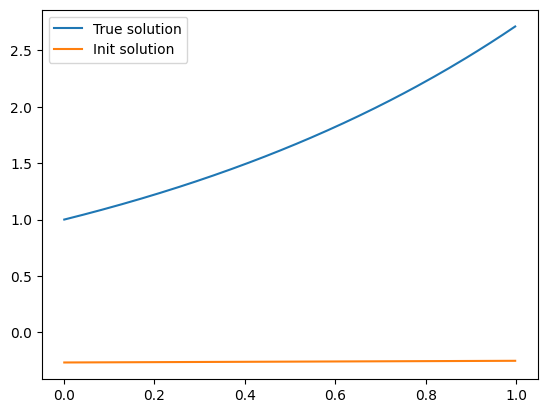

In [50]:
vectorized_u_init = vmap(lambda t: u(t, init_params), (0), 0)

def u_true(t):
    return u0 * jnp.exp(a * (t-t0) )

ts = train_data.times.sort(axis=0)
plt.plot(ts * Tmax, vmap(u_true, 0)(ts * Tmax), label="True solution")
plt.plot(ts * Tmax, vectorized_u_init(ts), label="Init solution")
plt.legend()

## Loss construction

In [51]:
from jinns.loss import ODE


class LinearFODE(ODE):

    def equation(self, t, u, params):
        # in log-space
        u_ = lambda t, p: u(t, p)[0]
        du_dt = jax.grad(u_, 0)(t, params)
        return du_dt - params.eq_params["a"]


fo_loss = LinearFODE(Tmax=Tmax)

In [52]:
loss_weights = jinns.loss.LossWeightsODE(dyn_loss=2.0, initial_condition=1.0)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fo_loss,
    initial_condition=(float(tmin), jnp.log(u0)),
)

In [53]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 62.1646614074707
Individual losses: {'dyn_loss': '62.09', 'initial_condition': '0.07', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [54]:
params = init_params

In [55]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-4)

In [56]:
n_iter = int(10000)

In [57]:
key, subkey = random.split(key)

In [58]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

[train] Iteration 0: loss value = 62.1595344543457
[train] Iteration 1000: loss value = 0.3646239638328552
[train] Iteration 2000: loss value = 0.16788983345031738
[train] Iteration 3000: loss value = 0.05390589311718941
[train] Iteration 4000: loss value = 0.017992869019508362
[train] Iteration 5000: loss value = 0.0009479622240178287
[train] Iteration 6000: loss value = 0.0017314533470198512
[train] Iteration 7000: loss value = 0.0011482611298561096
[train] Iteration 8000: loss value = 0.001325010322034359
[train] Iteration 9000: loss value = 0.0008850973681546748
Stopping main optimization loop, cause: max iteration is reached
Final iteration 10000: train loss value = 0.00030648111714981496


In [59]:
# loss_weights = jinns.loss.LossWeightsODE(dyn_loss=2.0, initial_condition=1.0)

# loss = jinns.loss.LossODE(
#     u=u,
#     loss_weights=loss_weights,
#     dynamic_loss=fo_loss,
#     initial_condition=(float(tmin), jnp.log(u0)),
# )

# params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
#     init_params=params,
#     data=train_data,
#     optimizer=tx,
#     loss=loss,
#     n_iter=n_iter
# )

## Results

Plot the loss values

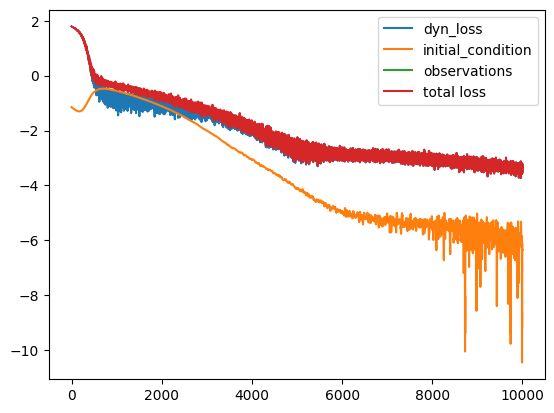

In [60]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

<Axes: xlabel='t'>

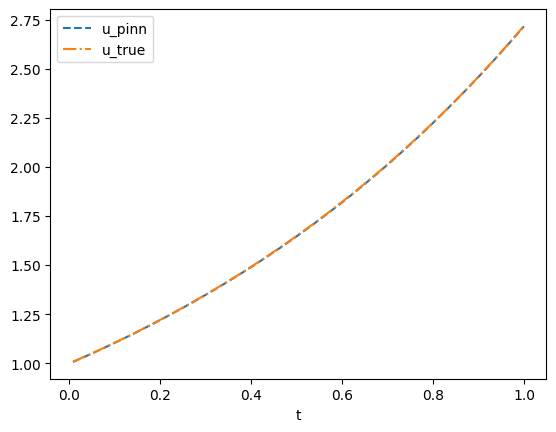

In [64]:
u_est_fp = vmap(lambda t:u(t, params), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

import pandas as pd
ts = val_data.times.sort(axis=0)
df = pd.DataFrame(
    {
        "t": ts * Tmax, # rescale time for plotting
        "u_pinn": jnp.exp(u_est_fp(ts).squeeze()),
        "u_true": vmap(u_true)(ts),
        "Method": "PINN"
    },
)
df.plot(x="t", style=["--", "-."])